# Analyzing Fantasy Football Data

In [1]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm

## Importing Data

In [2]:
# instantiate players dataframe
players = pd.DataFrame()

# read in weekly player data
base_path = 'https://raw.githubusercontent.com/fantasydatapros/data/master/weekly/'
for year in range(2018, 2021):
   year_path = base_path + str(year) + '/'
   for week in range(1, 18):
      week_path = year_path + 'week' + str(week) + '.csv'
      temp = pd.read_csv(week_path)
      temp.insert(1, 'Week', week)
      temp.insert(2, 'Year', year)
      players = pd.concat([players, temp], ignore_index=True)

# drop irrelevant columns
players.drop(columns=['PPRFantasyPoints', 'StandardFantasyPoints', 'Unnamed: 0'], inplace=True)

# view first few rows
players.head()

,Player,Week,Year,Pos,Tm,PassingYds,PassingTD,Int,PassingAtt,Cmp,RushingAtt,RushingYds,RushingTD,Rec,Tgt,ReceivingYds,ReceivingTD,FL,HalfPPRFantasyPoints
0,Ryan Fitzpatrick,1,2018,QB,TAM,417.0,4.0,0.0,28.0,21.0,12.0,36.0,1.0,0.0,0.0,0.0,0.0,0.0,42.28
1,Aaron Rodgers,1,2018,QB,GNB,286.0,3.0,0.0,30.0,20.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,24.94
2,Drew Brees,1,2018,QB,NOR,439.0,3.0,0.0,45.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.56
3,Patrick Mahomes,1,2018,QB,KAN,256.0,4.0,0.0,27.0,15.0,5.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,28.34
4,Joe Flacco,1,2018,QB,BAL,236.0,3.0,0.0,34.0,25.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,21.74


## Exploring Fantasy Point Distributions by Position

### Running Backs

In [24]:
rb = players[players['Pos'] == 'RB']

rb = rb.groupby('Player').mean().sort_values('HalfPPRFantasyPoints', ascending=False).HalfPPRFantasyPoints

rb_loc, rb_scale = norm.fit(rb)
print('rb_loc = {0}\trb_scale = {1}'.format(rb_loc, rb_scale))

rb_cdf = norm.cdf(rb, loc=rb_loc, scale=rb_scale)

rb_loc = 5.384792714272895	rb_scale = 4.763521379081649


### Wide Receivers

In [25]:
wr = players[players['Pos'] == 'WR']

wr = wr.groupby('Player').mean().sort_values('HalfPPRFantasyPoints', ascending=False).HalfPPRFantasyPoints

wr_loc, wr_scale = norm.fit(wr)
print('wr_loc = {0}\twr_scale = {1}'.format(wr_loc, wr_scale))

wr_cdf = norm.cdf(wr, loc=wr_loc, scale=wr_scale)

wr_loc = 4.984457141715371	wr_scale = 4.093978003700458


### Tight Ends

In [26]:
te = players[players['Pos'] == 'TE']

te = te.groupby('Player').mean().sort_values('HalfPPRFantasyPoints', ascending=False).HalfPPRFantasyPoints

te_loc, te_scale = norm.fit(te)
print('te_loc = {0}\tte_scale = {1}'.format(te_loc, te_scale))

te_cdf = norm.cdf(te, loc=te_loc, scale=te_scale)

te_loc = 3.4480661488500117	te_scale = 2.922459615671205


### Quarterbacks

In [27]:
qb = players[players['Pos'] == 'QB']

qb = qb.groupby('Player').mean().sort_values('HalfPPRFantasyPoints', ascending=False).HalfPPRFantasyPoints

qb_loc, qb_scale = norm.fit(qb)
print('qb_loc = {0}\tqb_scale = {1}'.format(qb_loc, qb_scale))

qb_cdf = norm.cdf(qb, loc=qb_loc, scale=qb_scale)

qb_loc = 9.072182891272215	qb_scale = 7.0119340328990845


Text(0.5, 1.0, 'Cumulative Distribution Functions of Mean Fantasy Points across Positions from 2018-2020')

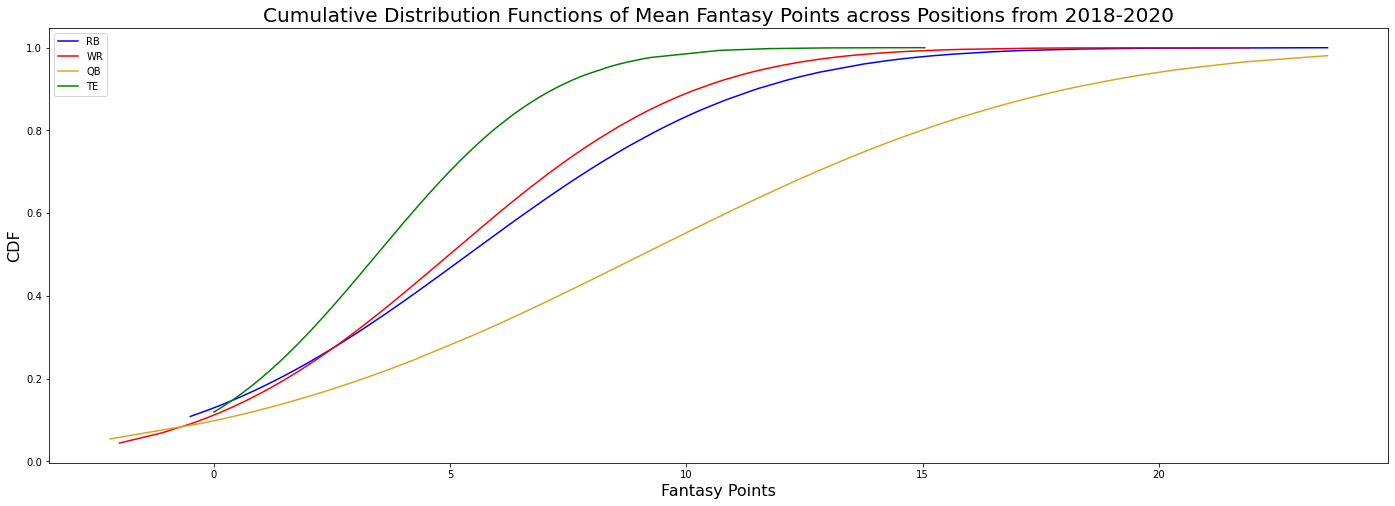

In [31]:
fig, ax = plt.subplots(1, figsize=(24,8))

sns.lineplot(x=rb, y=rb_cdf, ax=ax, color='blue', label='RB')
sns.lineplot(x=wr, y=wr_cdf, ax=ax, color='red', label='WR')
sns.lineplot(x=qb, y=qb_cdf, ax=ax, color='goldenrod', label='QB')
sns.lineplot(x=te, y=te_cdf, ax=ax, color='green', label='TE')

ax.legend(loc='upper left')
ax.set_xlabel('Fantasy Points', fontsize=16)
ax.set_ylabel('CDF', fontsize=16)
ax.set_title('Cumulative Distribution Functions of Mean Fantasy Points across Positions from 2018-2020', fontsize=20)